In [1]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
import sys

# -- Detect if in Own Install or in Colab
try:
    import google.colab
    OWN_INSTALL = False
except:
    OWN_INSTALL = True
    
if OWN_INSTALL:
    
  #---- Leave these definitions ON if running on laptop
  #---- Else turn OFF by putting them between ''' ... '''

  sys.path[0:0] = ['../../../../..',  '../../../../../3rdparty',  
                   '../../../..',  '../../../../3rdparty',  
                   '../../..',     '../../../3rdparty', 
                   '../..',        '../../3rdparty',
                   '..',           '../3rdparty' ]

else: # In colab
  ! if [ ! -d Jove ]; then git clone https://github.com/ganeshutah/Jove Jove; fi
  sys.path.append('./Jove')
  sys.path.append('./Jove/jove')

# -- common imports --
from jove.DotBashers import *
from jove.Def_md2mc  import *
from jove.Def_DFA    import *
from jove.LangDef    import *  # for testing DFA actions
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

You may use any of these help commands:
help(ResetStNum)
help(NxtStateStr)

You may use any of these help commands:
help(md2mc)
.. and if you want to dig more, then ..
help(default_line_attr)
help(length_ok_input_items)
help(union_line_attr_list_fld)
help(extend_rsltdict)
help(form_delta)
help(get_machine_components)

You may use any of these help commands:
help(mkp_dfa)
help(mk_dfa)
help(totalize_dfa)
help(addtosigma_delta)
help(step_dfa)
help(run_dfa)
help(accepts_dfa)
help(comp_dfa)
help(union_dfa)
help(intersect_dfa)
help(pruneUnreach)
help(iso_dfa)
help(langeq_dfa)
help(same_status)
help(h_langeq_dfa)
help(fixptDist)
help(min_dfa)
help(pairFR)
help(state_combos)
help(sepFinNonFin)
help(bash_eql_classes)
help(listminus)
help(bash_1)
help(mk_rep_eqc)
help(F_of)
help(rep_of_s)
help(q0_of)
help(Delta_of)
help(mk_state_eqc_name)

You may use any of these help commands:
help(lphi)
help(lunit)
help(lcat)
help(lexp)
help(lunion)
help(lstar)
help(srev)
help(lrev)
help(shomo)
help(lhomo)
he

In [2]:
def mkp_dfa(Q, Sigma, Delta, q0, F):
    """In : Traits of a DFA
       Out: A DFA
       Check for partial consistency of the given DFA traits.
       If the check passes, make and return a DFA with a partial 
       Delta.
    """
    newDFA = {"Q":Q, "Sigma":Sigma, "Delta":Delta, "q0":q0, "F":F}
    assert(
        is_partially_consistent_dfa(newDFA)
    ), "DFA given to mkp_dfa is not partially consistent. Plz check its components."
    return(newDFA)

def mk_dfa(Q, Sigma, Delta, q0, F):
    """In : Traits of a DFA
       Out: A DFA
       Check for structural consistency of the given DFA traits.
       If the check passes, make and return a DFA with a total 
       Delta.
    """
    newDFA = {"Q":Q, "Sigma":Sigma, "Delta":Delta, "q0":q0, "F":F}
    assert(
        is_consistent_dfa(newDFA)
    ), "DFA given to mk_dfa is not consistent. Plz check its components."
    return(newDFA)

def totalize_dfa(D):
    """In : Partially consistent DFA
       Out: A consistent DFA 
       Given a partially specified DFA, make it total by 
       transitioning to state BH wherever the incoming Delta 
       has gaps. The returned DFA is structurally consistent.
    """
    assert(
        is_partially_consistent_dfa(D)
    ), "DFA given to totalize_dfa is not partially consistent."
    if set(fn_dom(D["Delta"])) == set(product(D["Q"], D["Sigma"])):
        # It is already total!
        return D 
    else:        
        # We must introduce a BH state of not already present
        # and proceed from there
        incoming_Delta = D["Delta"].copy()
    
        # Gaps in incoming_Delta's transition function are sent
        # to the BH (black-hole) state
        gaps_in_Tr = { (q,c) : "BH" for q in D["Q"] for c in D["Sigma"] 
                       if (q,c) not in D["Delta"] }
    
        # We are gonna add a new black-hole-state.
        # It must curl back to itself for every symbol in Sigma
        bh_self_absorbent_moves = { ("BH", c): "BH" for c in D["Sigma"] }

        # Fill the gaps in incoming_Delta
        incoming_Delta.update( gaps_in_Tr )
    
        # Add in the moves where the black-hole state curls 
        # back to itself
        incoming_Delta.update( bh_self_absorbent_moves )
        
        # All updates required are accomplished
        finished_Delta = incoming_Delta
    
        # See that we update D["Q"] with the "BH" (black-hole) 
        # state; also return the fixed-up incoming_Delta
        return {"Q"    : D["Q"] | { "BH" }, 
                "Sigma": D["Sigma"],    
                "Delta": finished_Delta,
                "q0"   : D["q0"],          
                "F"    : D["F"] }
    


In [3]:
DFA_B0 = md2mc('''DFA !! DFA for words beginning with 0's
I : 0   -> F
I : 1   -> B
B : 0|1 -> B
F : 0|1 -> F
''')

In [4]:
DFA_B0

{'Q': {'B', 'F', 'I'},
 'Sigma': {'0', '1'},
 'Delta': {('I', '0'): 'F',
  ('I', '1'): 'B',
  ('B', '0'): 'B',
  ('B', '1'): 'B',
  ('F', '0'): 'F',
  ('F', '1'): 'F'},
 'q0': 'I',
 'F': {'F'}}

In [5]:
DFA_B0["Delta"][('I','0')]

'F'

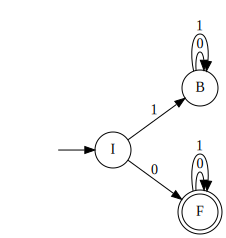

In [6]:
dotObj_dfa(DFA_B0)

In [7]:
DFA_E1 = md2mc('''DFA !! accepts words that end in a 1  
I : 1   -> F
I : 0   -> I
F : 1   -> F
F : 0   -> I
''')

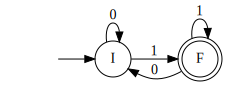

In [8]:
dotObj_dfa(DFA_E1)

In [9]:
def step_dfa(D, q, c):
    """In : D (consistent DFA)
            q (state in D)
            c (symbol in D's sigma)
       Out: next state of q via c (state in D) 
    """
    assert(c in D["Sigma"]), "step_dfa given c not in Sigma."
    assert(q in D["Q"]), "step_dfa given q not in Q."
    return D["Delta"][(q,c)]

def run_dfa(D, s):
    """In : D (consistent DFA)
            q (state in D)
            s (string over D's sigma, including "")
       Out: next state of q via s (state in D) 
    """    
    state = D["q0"]
    while s != "":
        state = step_dfa(D, state, s[0])
        s = s[1:]
    return state

def accepts_dfa(D, s):
    """In : D (consistent DFA)
            s (string over D's sigma, including "")
       Out: Boolean (if state after s-run is in D's final).
    """
    return run_dfa(D, s) in D["F"]


In [10]:
accepts_dfa(DFA_E1, "001")

True

In [11]:
accepts_dfa(DFA_B0, "000")

True

In [12]:
DFA_B0_and_E1 = intersect_dfa(DFA_B0, DFA_E1)

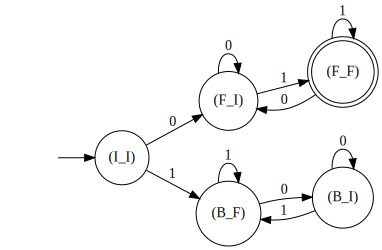

In [13]:
dotObj_dfa(DFA_B0_and_E1)

In [14]:
DFA_B0_or_E1 = union_dfa(DFA_B0, DFA_E1)

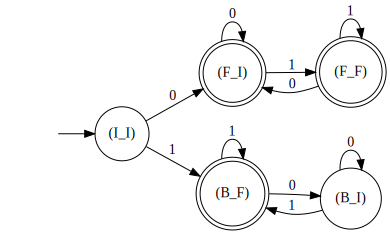

In [15]:
dotObj_dfa(DFA_B0_or_E1)

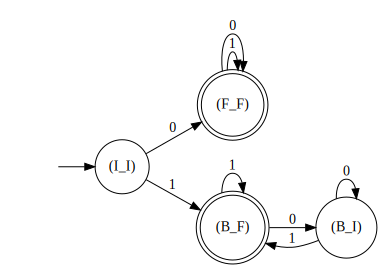

In [16]:
dotObj_dfa(min_dfa(DFA_B0_or_E1))

## DFA complementation

DFA complementation works by flipping the final and non-final states. We must check that the DFA is totalized before we embark on that, as the 'black-hole' state will now become 'white-hole' (a final state from which all symbols lead back to itself).

In [17]:
def comp_dfa(D):
    """In : D (DFA : partially consistent)
       Out: Consistent DFA that is D's complement.
       Before we begin, make D total. This is crucial, 
       as the black-hole states if any
       become "white-hole" states in the complemented DFA 
       (i.e. really turn into accepting 
       states from which one can't get out).
       Then flip the FINAL and NON-FINAL states.
    """
    Dtot = totalize_dfa(D)
    return mk_dfa(D["Q"],D["Sigma"],D["Delta"],D["q0"],D["Q"]-D["F"])


In [18]:
DFA_comp_B0_or_E1 = comp_dfa(DFA_B0_or_E1)

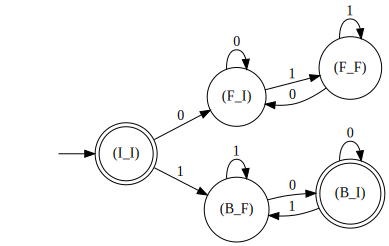

In [19]:
dotObj_dfa(DFA_comp_B0_or_E1)

In [20]:
DFA_comp_compB0_or_compE1 = comp_dfa(union_dfa(comp_dfa(DFA_B0), comp_dfa(DFA_E1)))

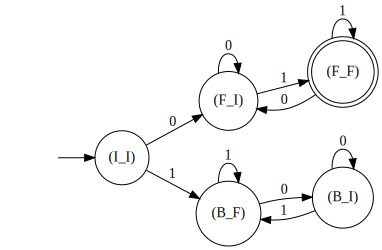

In [21]:
dotObj_dfa(DFA_comp_compB0_or_compE1)

## DFA Union

DFA union has a straightforward definition as in the book. We march the DFAs in tandem. We accept if either DFA accepts_dfa.

In [22]:
def union_dfa(D1in, D2in):
    """In : D1in (consistent DFA)
            D2in (consistent DFA)
       Out: DFA for language union of D1in, D2in (consistent DFA). 
    """
    assert(is_consistent_dfa(D1in)), "Inconsist. DFA1 in union_dfa"
    assert(is_consistent_dfa(D2in)), "Inconsist. DFA2 in union_dfa"
    if (D1in["Sigma"] != D2in["Sigma"]):
        print("Union on DFA with different alphabets.")
        print("Making alphabets the same (taking unions).")
        Sigma = D1in["Sigma"] | D2in["Sigma"]
        D1   = copy.deepcopy(D1in)
        D2   = copy.deepcopy(D2in)
        D1["Sigma"] = Sigma
        D2["Sigma"] = Sigma
        D1 = totalize_dfa(D1)
        D2 = totalize_dfa(D2)
    else:
        D1 = totalize_dfa(D1in)
        D2 = totalize_dfa(D2in)
   
    # The states can be anything in the cartesian product
    Q     = set(product(D1["Q"], D2["Q"]))
    
    # Accept if one of the DFAs accepts
    F     = (set(product(D1["F"], D2["Q"])) | 
             set(product(D1["Q"], D2["F"])))
    
    # Start a lock-step march from the respective q0
    q0    = (D1["q0"], D2["q0"])
    
    # The transition function attempts to march both
    # DFAs in lock-step per their own transition functions
    Delta = { ((q1,q2),ch) : (q1p, q2p) 
               for q1 in D1["Q"] for q1p in D1["Q"] 
               for q2 in D2["Q"] for q2p in D2["Q"] 
               for ch in D1["Sigma"] 
               if D1["Delta"][(q1,ch)] == q1p and
                  D2["Delta"][(q2,ch)] == q2p }
                                                          
    return pruneUnreach(
        mk_dfa(Q, D1["Sigma"], Delta, q0, F))

In [23]:
def intersect_dfa(D1in, D2in):
    """In : D1in (consistent DFA)
            D2in (consistent DFA)
       Out: DFA for language intersection of D1in, D2in (consistent DFA). 
    """
    assert(is_consistent_dfa(D1in)), "Inconsist. DFA1 in intersect_dfa"
    assert(is_consistent_dfa(D2in)), "Inconsist. DFA2 in intersect_dfa"
    if (D1in["Sigma"] != D2in["Sigma"]):
        print("Intersection on DFA with different alphabets.")
        print("Making alphabets the same (taking unions).")
        Sigma = D1in["Sigma"] | D2in["Sigma"]
        D1   = copy.deepcopy(D1in)
        D2   = copy.deepcopy(D2in)
        D1["Sigma"] = Sigma
        D2["Sigma"] = Sigma
        D1 = totalize_dfa(D1)
        D2 = totalize_dfa(D2)
    else:
        D1 = totalize_dfa(D1in)
        D2 = totalize_dfa(D2in)
 
    Q     = set(product(D1["Q"], D2["Q"]))
    
    # This is the only difference with the union:
    # The final states are those when both DFA accept
    F     = set(product(D1["F"], D2["F"]))
           
    q0    = (D1["q0"], D2["q0"])
    Delta = { ((q1,q2),ch) : (q1p, q2p) 
               for q1 in D1["Q"] for q1p in D1["Q"] 
               for q2 in D2["Q"] for q2p in D2["Q"] 
               for ch in D1["Sigma"] 
               if D1["Delta"][(q1,ch)] == q1p and
                  D2["Delta"][(q2,ch)] == q2p }
                                                          
    return pruneUnreach(
        mk_dfa(Q, D1["Sigma"], Delta, q0, F))

### Eliminating unreachable states

Let us write the code for eliminating unreachable states. Function pruneUnreach(DFA) returns a new DFA with unreachable states in the input DFA removed (all transitions from them are also removed).

In [24]:
def pruneUnreach(D):
    """In : D (consistent DFA)
       Out: Consistent DFA.
       Given a consistent (and of course total) DFA D,
       returns a new (consistent) DFA with unreachable 
       states in D removed. Transitions from each unreachable 
       state are also removed. Reachable states are those that
       can be reached in |D["Q"]| - 1 steps or less.
    """
    Nsteps   = len(D["Q"]) - 1 # Search this far
    Frontier = set({D["q0"]})  # BFS frontier
    AccumF   = Frontier        # Used to accumulate Frontier changes
    for n in range(Nsteps):
        for q in Frontier:
            for ch in D["Sigma"]:
                AccumF = AccumF | set({step_dfa(D, q, ch)})
        Frontier = AccumF
        
    newQ     = Frontier
    newF     = D["F"] & Frontier
    newDelta = dict({ ((q,ch),qp) 
                      for ((q,ch),qp) in fn_trans(D["Delta"]) 
                      if q in Frontier })
    return mk_dfa(Frontier, D["Sigma"], newDelta, D["q0"], newF)

# DFA Isomorphism

This routine is handy to check whether two DFA are isomorphic. Given they are rooted at q0, the isomorphism-check is linear in the number of edges.

In [25]:
def iso_dfa(D1,D2):
    """Given consistent and total DFAs D1 and D2,
       check whether they are isomorphic. Two DFAs
       are isomorphic if they have the same number
       of states and are language-equivalent. (One would
       then be able to match-up state for state and transition
       for transition.)
    """
    assert(is_consistent_dfa(D1)), "Inconsist. DFA1 in iso_dfa"
    assert(is_consistent_dfa(D2)), "Inconsist. DFA2 in iso_dfa"
    return (len(D1["Q"]) == len(D2["Q"]) and
            langeq_dfa(D1, D2))

In [26]:
def langeq_dfa(D1, D2, gen_counterex=False):
    """Given consistent and total DFAs D1 and D2,
       check whether they are language-equivalent. 
       gen_counterex is a flag that triggers the
        printing of a counter-example showing the
        pairs that were marched in tandem till a
        difference was found.
        
       Two DFAs are language-equivalent if they 
       accept the same set of strings. We determine
       this through a joint depth-first walk of the 
       two DFAs until we detect a difference (return
       False then) or all pairs of states have been
       visited (return True then).
    """
    if D1["Sigma"] != D2["Sigma"]:
        print("The DFA cannot be compared, as their", end="")
        print(" alphabets are different; namely:")
        print("Sigma1 = ", D1["Sigma"])
        print("Sigma2 = ", D2["Sigma"])
        return False
    else:
        (eqStatus, cex_path) = h_langeq_dfa(D1["q0"], D1,
                                            D2["q0"], D2, 
                                            Visited=[])
        if not eqStatus:
            if gen_counterex:
                print("The DFA are NOT language equivalent!")
                print("Path leading to counterexample is: ")
                print(cex_path)
        return eqStatus # True or False

def same_status(q1, D1, q2, D2):
    """Check if q1,q2 are both accepting
       or both non-accepting wrt D1,D2 resply.
    """
    return (q1 in D1["F"]) == (q2 in D2["F"])

def h_langeq_dfa(q1, D1, q2, D2, Visited):
    """Helper for langeq_dfa. 
       If (q1,q2) is in Visited, no screw-up so far, so
        continue. Else if they agree in status, recursively
        check for all reachable configurations (a DFS in
        recursion). Else (if they differ in status),
        then return (False, Visited) where the latter is
        the counter-example trace.  
    """
    if (q1,q2) in Visited:
        return (True, Visited)
    else:
        extVisited = Visited + [(q1,q2)]
        if not same_status(q1,D1,q2,D2):
            return (False, extVisited)
        else:
            l_nxt_status = list(
            map(lambda symb:
                h_langeq_dfa(D1["Delta"][(q1,symb)], D1,
                             D2["Delta"][(q2,symb)], D2,
                             extVisited),
                D1["Sigma"]))
            l_rejects = list(filter(lambda x: x[0]==False, l_nxt_status))
            if l_rejects==[]:
                return (True, extVisited)
            else:
                return l_rejects[0] # which is the first offending (status,cex)

In [27]:
langeq_dfa( DFA_comp_compB0_or_compE1 , DFA_B0_and_E1 )

True

In [28]:
iso_dfa( DFA_comp_compB0_or_compE1 , DFA_B0_and_E1 )

True

In [29]:
min_DFA_B0_or_E1 = min_dfa(DFA_B0_or_E1)

In [30]:
langeq_dfa(DFA_B0_or_E1, min_DFA_B0_or_E1)

True

In [31]:
iso_dfa(DFA_B0_or_E1, min_DFA_B0_or_E1)

False

# DFA Minimization

This is a good juncture at which to introduce DFA minimization. 

## Definition of DFA minimization

We define minimization only for consistent DFA.
 
> _A consistent DFA D is minimal if it satisfies two properties_
 
>  1. There should not be any unreachable states (from the start state) in it
 
>  2. For any pair of distinct states $(s_1,s_2)$ in $D$, we must not have the case that for all strings $s$ in $\Sigma^*$, $\hat{\delta}(s_1,s) = \hat{\delta}(s_2,s)$.


We don't want useless states and we don't want redundant states. For instance, let me make a redundant DFA with duplicate states, below. Then you can easily see how even bloated DFAs can recognize the same language. After seeing this fact, we will introduce you to a DFA minimization algorithm.

First, let's learn how to deliberately bloat a DFA:

## DFA minimization algorithm (high level)

Having seen two examples of bloated DFA, we now define a minimization algorithm. Here is the gist. The actual algorithm is in the code that follows.

1. Put the states into two equivalence classes (EC):

 a. All non-final states are in one EC, say NF
 b. All final states are in another EC, say F
 c. We call any (sa,sb) such that sa in NF and sb in F as **zero-distinguishable** states, as 
    a $\varepsilon$ string can distinguish sa and sb (meaning, when sa is evolved through $\varepsilon$ or $sb$ is evolved through $\varepsilon$, the resulting state is the same -- sa or sb)
    
     * "Evolved through" means $\hat{\delta}(sa,\varepsilon) = sa$, and similarly for sb
     
     * In our example DFA d34bl, IF is zero-distinguishable from all other states
 
2. In general, we have $k$-distinguishable states for $k>0$ (above step discussed $k=0$ as zero-distinguishability)

3. Split states:
 
 a. Take a state pair $(s_1,s_2)$ such that they are not $k$ distinguishable.
 b. Take $c\in\Sigma$
 c. If $\delta(s_1,c) = sn_1$ and $\delta(s_2,c) = sn_2$ and $(sn_1,sn_2)$ are $k$-distinguishable, mark $(s_1,s_2)$ as $k+1$-distinguishable. 
 
4. Repeat the above process till across one sweep, the distinguishability relation does not change.

5. Take all maximal sets of pairs of states that have not been found distinguishable yet. Pick a representative from each such maximal set. These states are in the final DFA. 

6. Go by the state transitions of the representative states. (The remaining states in the equivalence classes are not necessary.)

  * In our example, all pairs in $\{A,A1\} \times \{B,B1\}$ will be 1-distinguishable (distinction made by $0$)
  
  * The final equivalence classes will be $\{IF\}$, and then $\{A,A1\}$, and $\{B,B1\}$.
  

<span style="color:blue"> **Clearly, the above algorithm cannot make full sense till you see how it can be worked out "by hand" using some pictures. This is what we will now do before showing you the actual code.

** </span>


## A fully worked-out example

<font size="3"> 

This is the initial display of a matrix (only the lower half shown, as the upper half is symmetric). The matrix shows "." which are points at which state pairs "collide." The dots in this figure allow for these pairs to collide (we show pairs only one way, i.e. (P,Q) and not the other way i.e. (Q,P) also).

</font>

<font size="4"> 


```

A   .

A1  .   .

B   .   .   .

B1  .   .   .   .

    IF  A   A1  B
    
The above is a convenient arrangement to talk about these pairs:


(A, IF),

(A1, IF), (A1, A)

(B, IF),  (B, A),  (B, A1)

(B1, IF), (B1, A), (B1, A1), (B1, B)

Now, here is how the computation proceeds for this example:
===========================================================

Frame-0              Frame-1                Frame-2                
 
A   -1                A   0                  A   0                 

A1  -1   -1           A1  0   -1             A1  0   -1            
 
B   -1   -1  -1       B   0   -1   -1        B   0   1   1         

B1  -1   -1  -1  -1   B1  0   -1   -1  -1    B1  0   1   1   -1    

    IF   A   A1  B        IF  A    A1  B         IF  A   A1  B         
    
    
Frame-3 = Frame-2   

A   0 

A1  0   -1

B   0   1   1

B1  0   1   1   -1

    IF  A   A1  B   
``` 

<br>
<br>

Let's see another example as well. We will explain the second 
example (we leave the above example wrt **D34bl** as something you can explain.

</font>


Now, here is how the computation proceeds for this example:
-------------------------------------------------------- 
 
 <br>
 
<font size="3"> 


```
 
Frame-0                  Frame-1                   Frame-2                    
                                                                                                     
S2  -1                   S2   0                    S2   0                     

S3  -1  -1               S3   0  -1                S3   0  -1                 

S4  -1  -1  -1           S4  -1   0   0            S4   2   0   0             

S5  -1  -1  -1  -1       S5  -1   0   0  -1        S5   2   0   0  -1         

S6  -1  -1  -1  -1  -1   S6   0  -1  -1   0   0    S6   0   1   1   0   0     

    S1  S2  S3  S4  S5       S1  S2  S3  S4  S5        S1  S2  S3  S4  S5        

Initial                  0-distinguishable         1-distinguishable                         
     
     
Frame-3                 Frame-4     
                        =
                        Frame-3

S2   0

S3   0  -1

S4   2   0   0

S5   2   0   0  -1

S6   0   1   1   0   0

    S1  S2  S3  S4  S5
    
2-distinguishable 
     
```
</font>

Here is the algorithm, going frame by frame.

- Initial Frame: 

     The initial frame is drawn to clash all _combinations_ of states taken two at a time.
     Since we have 6 states, we have $6\choose 2$ = $15$ entries. We put a -1 against each
     such pair to denote that they have not been found distinguishable yet.

- Frame *0-distinguishable*: We now put a 0 where a pair of states is 0-distinguishable. This means the states are distinguisable after consuming $\varepsilon$. This of course means that the states are themselves distinguishable. This is only possible if one is a final state and the other is not (in that case, one state, after consuming $\varepsilon$ accepts_dfa, and another state after consuming $\varepsilon$ does not accept.

  - So for instance, notice that (S3,S1) and (S4,S2) are 0-distinguishable, meaning that one is a final and the other is a non-final state.

- Frame *1-distinguishable*: We now put a 1 where a pair of states is 1-distinguishable. This means the states are distinguisable after consuming a string of length $1$ (a single symbol). This is only possible if one state transitions to a final state and the other transitions to a non-final state after consuming a member of $\Sigma$. 

  State pairs (S6,S2) and (S6,S3) are of this kind. While both S6 and S2 are final states (hence _0-indistinguishable_), after consuming an 'a' (or a 'b') they respectively go to a final/non-final state.
 This means that

  - after processing **the same symbol** one state -- let's say pre_p -- finds itself landing in a state p and another state  -- let's say pre_q -- finds itself landing in a state q such that (p,q) is 0-distinguishable.
  
  - When this happens, states pre-p and pre-q are **1-distinguishable**.

- Frame *2-distinguishable*: We now put a 2 where a pair of states is 2-distinguishable. This means the states are distinguisable after consuming a string of length $2$ (a string of length $2$). This is only possible if one state transitions to a state (say p) and the other transitions to state (say q) after consuming a member of $\Sigma$ such that (p,q) is **1-distinguishable**. State pairs (S5,S1) and (S4,S1) are 2-distinguishable because

  - after processing **the same symbol** one state -- let's say pre_p -- finds itself landing in a state p and another state  -- let's say pre_q -- finds itself landing in a state q such that (p,q) is 0-distinguishable.
  
  - When this happens, states pre-p and pre-q are **1-distinguishable**.
  
  - One example is this:
  
    - S5 and S1 are 2-distinguishable.
    
    - This is because after seeing an 'aa', S1 lands in a non-final state while S5 lands in a final state
    
    - Observe that "aa" = "a" + "a" . Thus, after eating the first "a", S1 lands in S2 while S5 lands in S6, and (S2,S6) have already been deemed 1-distinguishable.
    
    - Thus, when we mark (S5,S1) as 2-distinguishable, we are sending the matrix entry at (S5,S2) from 
      -1 to 2
 


  - Now, in search of 3-distinguishability, we catch hold of all pairs in the matrix and see if we can send another -1 entry to "3". This appears not to happen. 
  
     - Thus, if (S2,S3) is pushed via any sequence of symbols (any string) of any length, it
       always stays in the same type of state. Thus, after seeing 'ababba', S2 is in S6, while S3 
        is also in S6.


 - Thus, given no changes in the matrix, we stop.

## Code for DFA minimization

We now provide the code for DFA minimization, referring to the above narrative to keep us focused as to which part of the algorithm we are implementing.

### The heart of the algorithm is function fixptDist. This seeks the fixpoint (or "fixed-point") of the Dist (or Distinguishability) relation. Neat eh?

A fixpoint of a function f is a value x such that f(x) = x. In our case, the functiion in question is one that take the entire matrix (frame) and tries to spit out the next matrix (frame). When we get a matrix m such that f(m) = m, the matrix has stabilized.

In our case, we obtain a fixpoint of the function with respect to input value "ht" (hash-table) representing our matrix. We also pass along the DFA in question ("D") that is a read-only argument (to consult its transition function, etc).

See how the code speaks for itself:

* We set "changed = True" outside a while loop, and enter this loop "while changed".

* We set changed = False, hoping to get out

  - Any change-causing activity (n-distinguishability for some n) will set changed back to True
  
  - If not, we will "get out of the jail"
  
  - Termination is guaranteed. Why?
    
      * There are only a finite number of states
      
      * If we pump a long-enough string from a pair of states,
      
          - Clearly, it can try to meander, visiting fresh state pairs that are m-distinguishable for 
             an m <= n (those other state pairs and their distinguishability distance
             were generated in an earlier pass or the current pass)
             
      * In short, for any pair of states (p,q), there is a maximal (loop-free) string s such that 
        $\hat{\delta}(p,s) \in F$ while $\hat{\delta}(q,s)\in (Q\setminus F)$. This is the highest the 
        distinguishability number can get to.
             
           - If $s$ has a loop, there is a shorter string that establishes the distinguishability 
              number.
         
         

We now go through all aspects of the code:

* We first iterate across "kv" (key,value) pairs in ht.items(), i.e. we iterate through all 
  the matrix entries (pairs) which are recorded in "ht" (the hash table). The value recorded is the
  distinguishability number.
  
* We obtain s0 and s1, the states that this hash-table entry is modeling.

* We iterate across all $c\in\Sigma$

* We obtain the next state after sending s0 and s1 via $c$

* If we land in the same next state (ns0 == ns1), we continue (try to "get out of the jail" by not
  resetting changed)
  
* If this is a visited pair (i.e. (ns0,ns1) in ht), then

  - If one is "-1" while the other is >= 0  (meaning they are distinguishable states)
     
       - then we set changed = True, and continue, breaking this iteration of the "for c"
       
       - else we examine it as pair (ns1, ns0). This is because "ht" does not store both 
          (ns0,ns1) and (ns1,ns0). But we have to check both ways
          
       - we apply the same logic
       
* If we can find distinguishability, we increase the ht number

* else we will get out of the loop!

In [32]:
def fixptDist(D, ht):
    """In : D (consistent DFA)
            ht (hash-table of distinguishability pair distances)
       Out: ht that has attained a fixpoint in distinguishability.
       Helper (but main workhorse) for min_dfa.
       Given an initial hash-table ht and a DFA D to be minimized,
       determine the min. distinguishability distances, going frame 
       by frame, as illustrated in the DFA minimization algorithm. 
       Return fixpoint ht. Fixpoint is when ht ceases to change.
    """
    changed = True
    while changed:
        changed = False
        for kv in ht.items():
            s0 = kv[0][0]
            s1 = kv[0][1]
            for c in D["Sigma"]:
                ns0 = D["Delta"][(s0,c)]
                ns1 = D["Delta"][(s1,c)]
                #
                # Distinguishable state pairs carry 
                # "distinguishability distance" in the ht
                if ns0 == ns1:
                    continue
                if (ns0, ns1) in ht:
                    # s0,s1 are distinguishable
                    if ht[(s0,s1)] == -1 and ht[(ns0, ns1)] >= 0: 
                        # acquire one more than the
                        # dist. number of (ns0,ns1)
                        ht[(s0,s1)] = ht[(ns0, ns1)] + 1          
                        changed = True                            
                        break
                else:
                    # ht stores only (ns0,ns1); 
                    # so check the other way
                    if (ns1, ns0) in ht:                              
                        if ht[(s0,s1)] == -1 and ht[(ns1, ns0)] >= 0:  
                            ht[(s0,s1)] = ht[(ns1, ns0)] + 1           
                            changed = True                             
                            break                                      
                    else:                                              
                        print("ht doesn't cover all reqd state combos.")
    return ht

In [33]:
def min_dfa(D, state_name_mode='succinct'):  # Default state mode
    """In : D (consistent DFA to be minimized)
       Out: Minimized version of D.
       The top-level callable DFA minimizer.
       Given a DFA D, go through the state minimization algorithm.
       state_name_mode is 'verbose' or 'succinct', producing two 
       variants, as you can guess.
       If the state_name_mode is verbose, we will make state names
       by stringing together the state names in the equivalence
       classes. Else we keep the name of the representative of 
       eqch equivalence class.
    """
    if (len(D["Q"]) == 1): # Already minimal
        return D
    else:
        # Build a dict of all state combinations of DFA.
        # Function state_combos also imparts a -1 for each state pair,
        # initializing the separation distance at -1.  
        ht = dict(state_combos(list(D["Q"])))
    
        # Mark final and non-final states to be 0-distinguishable.
        # This is achieved by putting a 0 against those state pairs.
        sepFinNonFin(D, ht)
    
        # Main fixpoint computation: Assigning distinguishability dist. 
        #==============================================================
        ht = fixptDist(D, ht)
    
        # Pick out equivalent state-pairs, i.e. those that cannot be 
        # distinguished. These are still with a "-1" in ht.
        ht_1 = [ stpair for (stpair, dist) in ht.items() if dist == -1 ]
    
        # Now form equivalence classes
        # what's returned is 
        # [(rep_1, [all_eql_states_1]), (rep_2, [all_eql_states_2]),...]
        # which includes all equivalence classes of size 2 or more.
        rep_eqc = bash_eql_classes(ht_1)

        # Now we have to deal with singleton equivalence classes. 
        # These sit unmerged, OUTSIDE OF ALL (x,y) in ht_1
        # i.e. all the entries in ht_1 are PARTNERED STATE PAIRS.  
    
        # If we now take D["Q"] and subtract from it all those x and y
        # which are present in some pair in ht_1, we obtain completely
        # non-mergable states. These are states in their own eql. classes.
    
        # 1. Find all partnered states from ht_1
        Partnered_states = list({x for (x,y) in ht_1} |
                                {y for (x,y) in ht_1})
    
        # 2. Now who is left un-partnered?
        List_of_self_only_eqlt_states = listminus(D["Q"], Partnered_states)                     
    
        # 3. For these singletons, i.e. "self-only equivalent states", 
        # they are self-representative. Form pairs that indicate this fact.
        rep_eqc_1 = [(x, [x]) for x in List_of_self_only_eqlt_states]
    
        # 4. OK now, we can combine the set of pairs where each pair is 
        # (representative, [the list of equivalent states])
        # So finally we get the list of equivalence classes with 
        # representatives  which is of this form:
        # [(a0,[a0, a1, a2, a3, a4]), (b0,[b0, b1]), (c0,[c0]), ...] 
        final_rep_eqc = rep_eqc + rep_eqc_1
    
        # We are now ready to build a DFA out of final_rep_eqc. 
        # =====================================================
    
        # 1. First, form the set of minimized states, which are 
        # state representatives.
        minQ = {x for (x,y) in final_rep_eqc}
    
        # 2. The Alpbahet remains the same.
        minSigma = D["Sigma"]
    
        # 3. The starting state is the representative of D["q0"]
        minq0 = q0_of(D["q0"], final_rep_eqc)
    
        # 4. The final states are the representatives of the original
        #    final states. This is computed by helper F_of.
        minF = F_of(D["F"], final_rep_eqc)
    
        # 5. The transition relation of the minimized DFA is obtained
        #    by the helper Delta_of
        minDelta = Delta_of(D["Delta"], final_rep_eqc)
    
        # 6. We now need to rename the states if the user wants verbose 
        #    names (default is succinct). Verbose names are the name of 
        #    states in each equivalence class strung together sep by "_".
        if state_name_mode == 'verbose':
            # First build a state-renaming hash-table involving 
            # mk_state_eqc_name
            state_rename_ht = { x : mk_state_eqc_name(y) 
                                for (x,y) in final_rep_eqc }
        
            minQ            = { state_rename_ht[x] for x in minQ }
            minq0           = state_rename_ht[minq0]
            minF            = { state_rename_ht[f] for f in minF }
            minDelta = { (state_rename_ht[x], y) : state_rename_ht[z] 
                         for ((x,y),z) in minDelta.items() }
        #
        # Return the finished (minimized) DFA!
        return mk_dfa(minQ, minSigma, minDelta, minq0, minF)

In [34]:
def pairFR(L):
    """In : L (list of states)
       Out: List of pairs with L[0] paired with each state in L[1:],
            with the distinguishability distance initialized to -1.
       Helper for generating state_combos.
    """
    return list(map(lambda x: ((L[0], x), -1), L[1:]))

In [35]:
def state_combos(L):
    """In : L (list of states)
       Out: List of combinations of L's states (rep. as pairs),
            with distinguishability distances marked as -1. 
       Helper for min_dfa.
       Given a list of DFA states L (assume length >= 2),
       Form state combinations, paired up as (L[i], L[i+1]).
       This forms the 'ht' that is acted upon by fixptDist.
    """
    if len(L) <= 2:
        return([((L[0], L[1]), -1)])
    else:
        return (pairFR(L)) + (state_combos(L[1:]))

In [36]:
def sepFinNonFin(D, ht):
    """In : D (consistent DFA)
            ht (hash table of distinguishability distances)
       Out: ht with (nonfinal,final) pairs in ht
            marked with a distinguishability distance of 0.
       Helper for min_dfa.
       Given a hash-table of separation distances and a DFA D,
       mark each state pair (final,non-final) with value 0
       indicating their 0-distinguishability.
    """
    # Form a separation predicate 
    sepPred = lambda x,y: (x in D["F"] and y in (D["Q"] - D["F"]) or 
                           y in D["F"] and x in (D["Q"] - D["F"]))
                         
    # Now separate all states where sepPred holds
    for kv in ht.items():
        if sepPred(kv[0][0], kv[0][1]):
            # Mark that this pair is 0-distinguishable
            ht[kv[0]] = 0

In [37]:
def bash_eql_classes(eql_reln):
    """In : eql_reln (equivalence relation : list of pairs of states).
       Out: List of equivalence classes with representatives.
            I.e. a structure of the form
            [ (state0, [state0, state1, state2,]), ... ]
            where state0 is a representative for the three (for example)
            equivalent states state0, state1, state2. There are as many
            such pairs as equivalence classes.
       Helper for min_dfa.
       Given an Eql. reln. of the form 
       [(a,b),(a,c),(d,e),(f,h),(g,f),..].
       1. Grow eql classes 
       2. Elect a representative for each eql class
       3. Return "equivalence classes with representatives."
       This is a structure of the form
        [(a0,[a0, a1, a2, a3, a4]), (b0,[b0, b1]), (c0,[c0]), ...] 
       where "a0" is a state and a0,a1,a2,a3,a4 are equivalent to it
       The same goes for the bs, cs, etc.
    """
    return bash_1(eql_reln, []) # seed with empty list of eql class sets.

In [38]:
def listminus(L1, L2):
    """In : L1 : list or set
            L2 : list or set
       Out: List of items in L1 that are not in L2.
       Helper for min_dfa and bash_1. Implements subtraction (L1 - L2).
    """
    return [x for x in L1 if x not in L2]

In [39]:
def bash_1(eql_reln, L_eq_classes):
    """In : eql_reln (equivalence relation : list of pairs of eqlt states)
            L_eq_classes (list of eql classes which are SETS of states 
            for now.)
       Out: return list of equivalence classes with representatives.
       Helper for bash_eql_classes. 
       1) eql_reln is the current equivalence relation 
          (list of pairs)
       2) L_eq_classes is a list of sets that are the eqlt 
          classes coalesced thus far.
       3) We remove one pair at a time from the eql_reln and find
          existing equivalence classes to expand, thus modifying
          L_eq_classes each time. 
       Once the equivalence relation is emptied, we call mk_rep_eqc
       thus making a list of equivalence classes with representatives
       of the form 
       [(a0,[a0, a1, a2, a3, a4]), (b0,[b0, b1]), (c0,[c0]), ...]. 
    """
    if eql_reln == []:
        # When we have fully processed the given equivalence 
        # relation, return a list of equivalence classes with 
        # representatives of the form 
        # [(a0,[a0, a1, a2, a3, a4]), (b0,[b0, b1]), (c0,[c0]), ...]
        return mk_rep_eqc(L_eq_classes)
    else:
        # pick the next pair from the eql_reln being coalesced
        eq0 = eql_reln[0]   
        a = eq0[0]          
        b = eq0[1]   
        
        # We know that a is a state that is equivalent to b, since
        # they exist as a pair in eql_reln[0].
        
        # Now we must see if 'a' already lives in a COALESCED 
        # equivalence class
   
        # Set Sa is a typical equivalence class in L_eq_classes
        # See if 'a' is in Sa.
        
        SaL = [Sa for Sa in L_eq_classes if a in Sa]
        
        # There must be zero or one such set as Sa. 
        # Thus, |SaL| = 0 or 1
        
        # Similarly, see which (if any) eql class that b lives in
        SbL = [Sb for Sb in L_eq_classes if b in Sb]  
        
        # Now there are four cases:
        
        # 1. a,b pair is totally new (not in any eql. class so far)
        if (SaL == [] and SbL == []):
            # Add a fresh eql class {a,b} to L_eq_classes and recurse
            return bash_1(eql_reln[1:], [{a,b}] + L_eq_classes)
        
        # 2. a is in eql class SaL[0] while b is not in any eql class
        elif (SbL == [] and not(SaL == [])):
            # Remove the little eql. class in which 'a' sits
            # replace by a bigger eql. class that now also includes 'b'. 
            # That is, we must invite 'b' into the same eql class 
            # in which 'a' sits (this being SaL[0]).
            
            # Then we take away the eql class that 'a' sits in from 
            # L_eq_classes, and of course replace it with an expanded 
            # version that includes b
            New_L_eq_classes = (listminus(L_eq_classes, SaL) +
                                [SaL[0] | {b}])
            
            return bash_1(eql_reln[1:], New_L_eq_classes)
        
        # 3. b is in eql class SbL[0] while a is not in any eql class
        elif (SaL == [] and not(SbL == [])):
            # Similar steps as above, with 'a' being invited in.
            
            New_L_eq_classes = (listminus(L_eq_classes, SbL) +
                                [SbL[0] | {a}])
            
            return bash_1(eql_reln[1:], New_L_eq_classes)
        
        else:
            # a and b are both in their own little eql. classes
            # We must now collapse both the eql classes into a huge one
            # Remove both little pre-existing eql. classes. Replace 
            # with union-ed one. Neither 'a' nor 'b' is being invited in
            # afresh; rather, the eql classes they are in 
            # (i.e. SaL[0],SbL[0]) are being merged.
            
            New_L_eq_classes = (listminus(L_eq_classes,SaL+SbL) + 
                                [SaL[0] | SbL[0]])
            
            return bash_1(eql_reln[1:], New_L_eq_classes)

In [40]:
def mk_rep_eqc(L_eq_classes):
    """Helper for bash_1 that finds the representative of a set of
       equivalent states. Given the final equivalence classes,
       make representatives for each; stick the repr. at the 
       head of a pair. Thus, (repr, eql-class-with-repr) list
       is returned.
    """
    Ll = list(map(lambda x: list(x), L_eq_classes))
    return list(map(lambda x: (x[0], x), Ll))

In [41]:
def F_of(F, final_rep_eqc):
    """In : F (final states of DFA)
            final_rep_eqc : equivalence class with representatives
       Out: A set of representatives of the final states 
       Helper for min_dfa.
       Given F, the final states of a DFA and final equivalence
       classes with representatives of the form 
       [(rep,[states eql to rep], ...)
       obtain those equivalence classes in which the original final 
       states live. Form a set of the representatives of these states. 
       This will be the set of representatives of the final states.
    """
    return { x for (x,X) in final_rep_eqc 
             if not (set(F) & set(X)) == set({}) }

In [42]:
def rep_of_s(s, final_rep_eqc):
    """Helper for min_dfa. Given a list 
       [(rep_of_s1, [states_eql_to_s1]),...]
       that has states paired with the list of equivalent states, 
       return the representative of s.
    """
    if final_rep_eqc == []:
        print("Error, did not find a rep for state s")
    else:
        x_X = final_rep_eqc[0]
        if s in x_X[1]:
            return x_X[0]
        else:
            return q0_of(s, final_rep_eqc[1:])    

In [43]:
def q0_of(q0, final_rep_eqc):
    """Helper for min_dfa. Given the initial state of the DFA and
       the list [(rep, [eql states]), ...], find the representative
       of q0 in lieu of q0.
    """
    return rep_of_s(q0, final_rep_eqc)

In [44]:
def Delta_of(Delta, final_rep_of_eqc):
    """In : Delta (transition function of the given DFA)
            final_rep_of_eqc (eql classes with representatives)
       Out: Form a dict of representatives' moves.
       Helper for min_dfa. 
       Given the original transition function Delta and the
       list [(rep_of_eqc, [equivalent states,...]), ...], 
       produce a new transition function with state representatives 
       (not the original states) jumping around!
       The nice thing is that if multiple states had jumped around, 
       their transitions AUTOMATICALLY GET MERGED when we pool 
       the transitions into a hash-table (dictionary). Thus, we are 
       merging transitions among equivalent states also.
    """
    return { (rep_of_s(s0, final_rep_of_eqc), a): 
              rep_of_s(s1, final_rep_of_eqc)  
              for  ((s0,a),s1) in Delta.items() }

In [45]:
def mk_state_eqc_name(L):
    """In : List of states (in each eql class)
       Out: single state names by bashing the states separated by "_".
       Helper for min_dfa. 
       Given a list of states, bash the 
       state names together separated by an underscore. 
       This is useful when 'verbose mode' state name printing 
       is desired.
    """
    return "_".join(L)

=== Now some space for experiments below! ====

In [46]:
YourDFA = DFA_B0   # "define your DFA here"

In [47]:
TestStrings = [nthnumeric(i, ['0','1']) for i in range(32)]

In [48]:
for test in TestStrings:
    if accepts_dfa(YourDFA, test):
        print("Your DFA accepts ", test)
    else:
        print("Your DFA rejects ", test)
	

Your DFA rejects  
Your DFA accepts  0
Your DFA rejects  1
Your DFA accepts  00
Your DFA accepts  01
Your DFA rejects  10
Your DFA rejects  11
Your DFA accepts  000
Your DFA accepts  001
Your DFA accepts  010
Your DFA accepts  011
Your DFA rejects  100
Your DFA rejects  101
Your DFA rejects  110
Your DFA rejects  111
Your DFA accepts  0000
Your DFA accepts  0001
Your DFA accepts  0010
Your DFA accepts  0011
Your DFA accepts  0100
Your DFA accepts  0101
Your DFA accepts  0110
Your DFA accepts  0111
Your DFA rejects  1000
Your DFA rejects  1001
Your DFA rejects  1010
Your DFA rejects  1011
Your DFA rejects  1100
Your DFA rejects  1101
Your DFA rejects  1110
Your DFA rejects  1111
Your DFA accepts  00000


In [49]:
list(filter(lambda x: accepts_dfa(YourDFA, x), TestStrings))

['0',
 '00',
 '01',
 '000',
 '001',
 '010',
 '011',
 '0000',
 '0001',
 '0010',
 '0011',
 '0100',
 '0101',
 '0110',
 '0111',
 '00000']

In [50]:
from jove.AnimateDFA import *
AnimateDFA(YourDFA, FuseEdges=False)
display(HTML('<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"/>'))

 "help(AnimateDFA)" gives you info on how to use animations with DFA 


=== Worked out before class ===

In [51]:

Odd0_and_Even1_DFA = md2mc(
"""
DFA

!! It really hurts one's head to directly design this machine

I : 0 -> F0
I : 1 -> S1

F0 : 0 -> S00
F0 : 1 -> S01

!! .. tedious .. 

""")

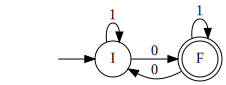

In [52]:
Odd0_DFA = md2mc(
"""
DFA
I : 0 -> F
I : 1 -> I

F : 0 -> I
F : 1 -> F
""")
dotObj_dfa(Odd0_DFA, FuseEdges="True")

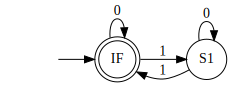

In [53]:
Even1_DFA = md2mc(
"""
DFA
IF : 0 -> IF
IF : 1 -> S1

S1 : 0 -> S1
S1 : 1 -> IF
""")
dotObj_dfa(Even1_DFA, FuseEdges="True")

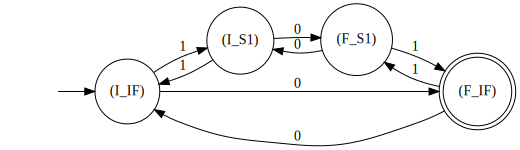

In [54]:
Odd0_and_Even1_alt = intersect_dfa(Odd0_DFA, Even1_DFA)
dotObj_dfa_w_bh(Odd0_and_Even1_alt, FuseEdges="True")

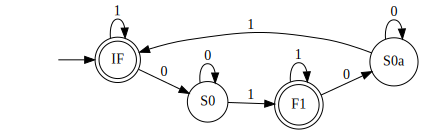

In [55]:
DFA_01_Star = md2mc(
"""
DFA

IF : 0 -> S0
IF : 1 -> IF

S0 : 0 -> S0
S0 : 1 -> F1

F1 : 0 -> S0a
F1 : 1 -> F1

S0a : 0 -> S0a
S0a : 1 -> IF

""")
dotObj_dfa(DFA_01_Star, FuseEdges="True")

Separating final and non-final states (marking 0-distinguishable entries).
   The 0-distinguishable entries are:
States  S0  and  IF  are 0-distinguished.
States  S0  and  F1  are 0-distinguished.
States  IF  and  S0a  are 0-distinguished.
States  F1  and  S0a  are 0-distinguished.
 
Seeing if states  S0  and  S0a  can now be distinguished by any symbol.
   The next states reached via symbol  1  are:  F1  and  IF
   Cannot distinguish yet, via  1
   The next states reached via symbol  0  are:  S0  and  S0a
   Cannot distinguish yet, via  0
 
Seeing if states  IF  and  F1  can now be distinguished by any symbol.
   The next states reached via symbol  1  are:  IF  and  F1
   Cannot distinguish yet, via  1
   The next states reached via symbol  0  are:  S0  and  S0a
   Cannot distinguish yet, via  0
 
Now, collecting equivalence-classes.
   The equivalent pairs are:
   The merged equivalent classes and representative states are these:
State  IF  represents the equivalent states  ['IF', 'F

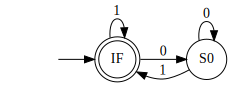

In [56]:
dotObj_dfa(min_dfa(DFA_01_Star, chatty=True), FuseEdges = "True")

=== A more elaborate eql. class merging illustration ===

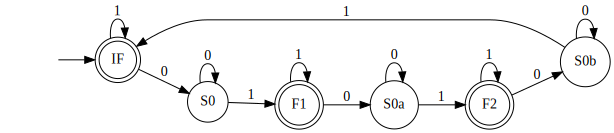

In [57]:
DFA_01_Star_3way = md2mc(
"""
DFA

IF : 0 -> S0
IF : 1 -> IF

S0 : 0 -> S0
S0 : 1 -> F1

F1 : 0 -> S0a
F1 : 1 -> F1

S0a : 0 -> S0a
S0a : 1 -> F2

F2  : 1 -> F2
F2  : 0 -> S0b

S0b : 0 -> S0b
S0b : 1 -> IF

""")
dotObj_dfa(DFA_01_Star_3way, FuseEdges="True")

Separating final and non-final states (marking 0-distinguishable entries).
   The 0-distinguishable entries are:
States  S0  and  F2  are 0-distinguished.
States  S0  and  IF  are 0-distinguished.
States  S0  and  F1  are 0-distinguished.
States  F2  and  S0b  are 0-distinguished.
States  F2  and  S0a  are 0-distinguished.
States  IF  and  S0b  are 0-distinguished.
States  IF  and  S0a  are 0-distinguished.
States  F1  and  S0b  are 0-distinguished.
States  F1  and  S0a  are 0-distinguished.
 
Seeing if states  S0  and  S0b  can now be distinguished by any symbol.
   The next states reached via symbol  1  are:  F1  and  IF
   Cannot distinguish yet, via  1
   The next states reached via symbol  0  are:  S0  and  S0b
   Cannot distinguish yet, via  0
 
Seeing if states  S0  and  S0a  can now be distinguished by any symbol.
   The next states reached via symbol  1  are:  F1  and  F2
   Cannot distinguish yet, via  1
   The next states reached via symbol  0  are:  S0  and  S0a
   Cannot d

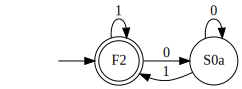

In [58]:
dotObj_dfa(min_dfa(DFA_01_Star_3way, chatty=True), FuseEdges = "True")